<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Обзор-данных" data-toc-modified-id="Обзор-данных-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Обзор данных</a></span></li><li><span><a href="#Лемматизация" data-toc-modified-id="Лемматизация-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Лемматизация</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Функции-для-обучения." data-toc-modified-id="Функции-для-обучения.-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Функции для обучения.</a></span></li><li><span><a href="#Модели" data-toc-modified-id="Модели-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Модели</a></span><ul class="toc-item"><li><span><a href="#LogisticRegression" data-toc-modified-id="LogisticRegression-2.2.1"><span class="toc-item-num">2.2.1&nbsp;&nbsp;</span>LogisticRegression</a></span></li><li><span><a href="#LinearSVC" data-toc-modified-id="LinearSVC-2.2.2"><span class="toc-item-num">2.2.2&nbsp;&nbsp;</span>LinearSVC</a></span></li><li><span><a href="#CatBoostClassifier" data-toc-modified-id="CatBoostClassifier-2.2.3"><span class="toc-item-num">2.2.3&nbsp;&nbsp;</span>CatBoostClassifier</a></span></li></ul></li><li><span><a href="#Тестирование-лучшей-модели" data-toc-modified-id="Тестирование-лучшей-модели-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Тестирование лучшей модели</a></span><ul class="toc-item"><li><span><a href="#Catboost" data-toc-modified-id="Catboost-2.3.1"><span class="toc-item-num">2.3.1&nbsp;&nbsp;</span>Catboost</a></span><ul class="toc-item"><li><span><a href="#Тест" data-toc-modified-id="Тест-2.3.1.1"><span class="toc-item-num">2.3.1.1&nbsp;&nbsp;</span>Тест</a></span></li><li><span><a href="#Регулирование-порога" data-toc-modified-id="Регулирование-порога-2.3.1.2"><span class="toc-item-num">2.3.1.2&nbsp;&nbsp;</span>Регулирование порога</a></span></li></ul></li></ul></li></ul></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

**Описание:** Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других.

**Задача бизнеса:** Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию.

**Цель проекта:**
- Обучить модель, которая будет классифицировать комментарии на позитивные и негативные.
- Добиться метрики качества F1 не меньше 0.75.

**Данные:** Набор данных с разметкой о токсичности правок.

**План**
- 1. Загрузить и изучить данные
  - Провести предобработку если потребуется
- 2. Обработать текст - провести Лемматизацию
- 3. Создать функции для обучения моделей, заложить в них трансфорцию и векторизацию текста
- 4. Обучить модели.
- 5. Протестировать лучшую модель.
- 6. Вывод.

## Подготовка

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import time

import spacy
import torch
import pymorphy2
import re 
import nltk
from nltk.corpus import stopwords 
from string import punctuation

from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.model_selection import train_test_split as tts, GridSearchCV as gs_cv, cross_val_score as cvs
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression as LR
from sklearn.dummy import DummyClassifier as DC
from sklearn.svm import LinearSVC as LSVC
from catboost import CatBoostClassifier as CBC

from sklearn.metrics import  f1_score, classification_report
from sklearn.metrics import roc_curve, roc_auc_score, auc

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set_style('darkgrid')

import warnings
warnings.filterwarnings('ignore')

s = 100500

### Обзор данных

In [2]:
try:
    df = pd.read_csv('/datasets/toxic_comments.csv', encoding='UTF-8')
except:
    df = pd.read_csv('toxic_comments.csv', encoding='UTF-8')
df

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0
...,...,...,...
159287,159446,""":::::And for the second time of asking, when ...",0
159288,159447,You should be ashamed of yourself \n\nThat is ...,0
159289,159448,"Spitzer \n\nUmm, theres no actual article for ...",0
159290,159449,And it looks like it was actually you who put ...,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


In [4]:
df.sample(5)

,Unnamed: 0,text,toxic
143448,143602,even if we hate furfags and llolis and kid fuc...,1
68214,68282,blocking\nYou are a company of wankers. instea...,1
14469,14485,"""\n\n point \n\ni have always made useful cont...",0
137635,137782,To the attention of mr. W. Waggel s.s.t.t.:,0
159052,159211,Its a shame one of the most experienced Fringe...,0


Нет пропущенных значений. Имеется три столбца, первый аналог индекса и от него можно избавиться. Следующие два столбца содержат целевой признак (Токсичность комментариев) и текстовый признак.

In [5]:
df = df.drop('Unnamed: 0', axis=1).copy()

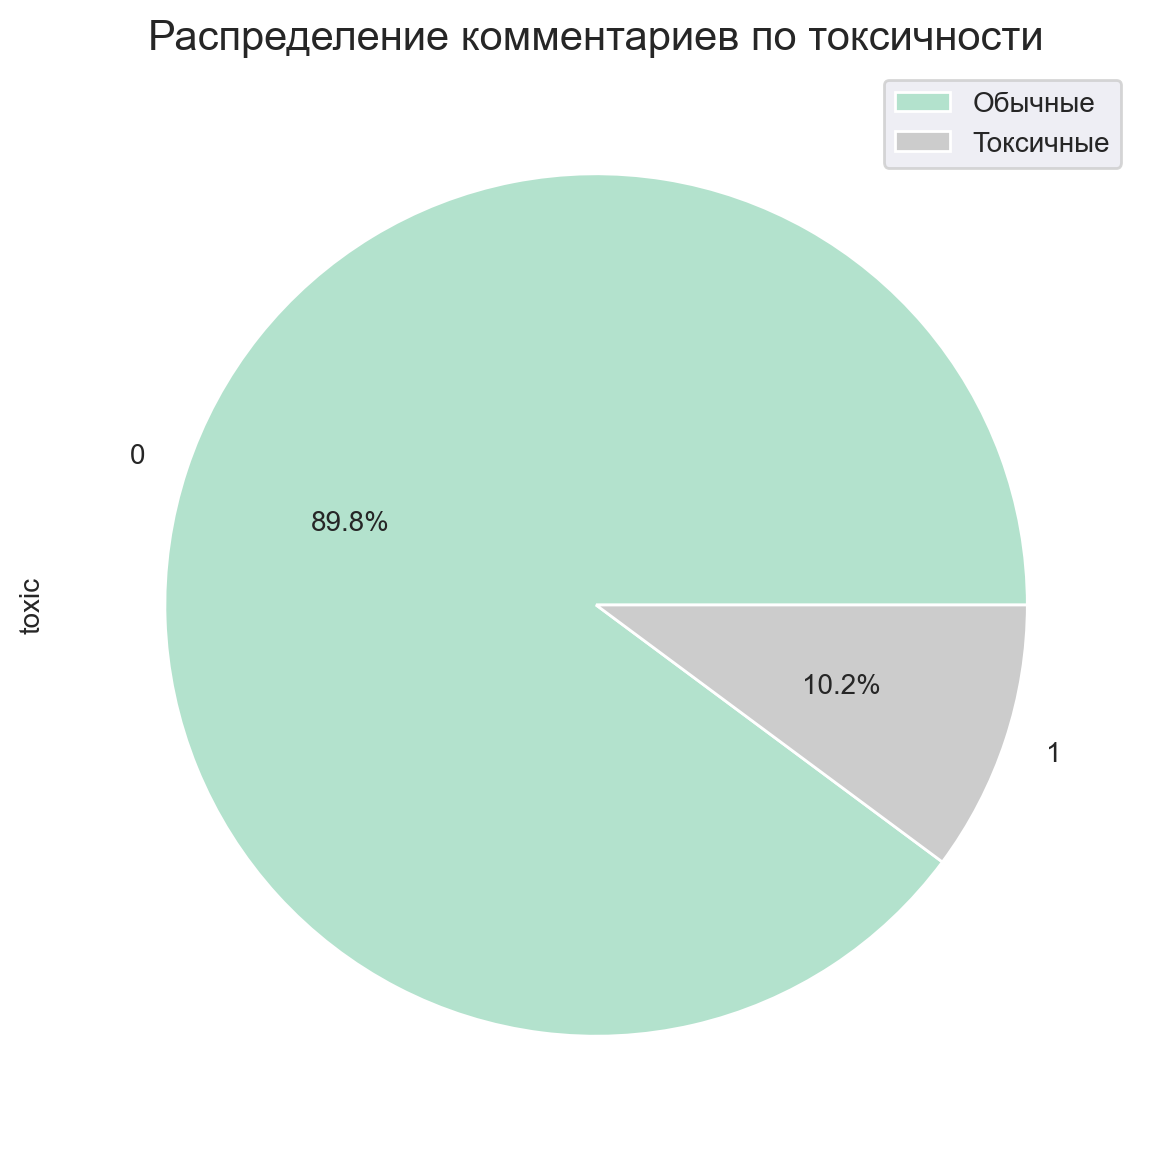

In [6]:
df.toxic.value_counts(normalize=True).plot.pie(figsize=(7,7),autopct='%1.1f%%',cmap='Pastel2',legend=True)
plt.legend(['Обычные','Токсичные'])
plt.title('Распределение комментариев по токсичности',size=15)
plt.show()

Имеется дисбаланс классов 9:1 - токсичный комментарии встречаються в 9 раз реже прочих. Это надо будет учитывать при обучении моделей. Возможно придёться поставить балансировку классов или подтянуть порог.

Так как у нас только 0 и 1, то можо поменять тип столба на uint8 для экономии места.

In [7]:
df['toxic'] = pd.to_numeric(df['toxic'], downcast='unsigned')

size1 = sys.getsizeof(pd.read_csv('toxic_comments.csv',encoding='UTF-8'))/1024/1024
size2 = sys.getsizeof(df)/1024/1024

print('Изначальное размер датафрейма:',np.round(size1,2),'МБ.')
print('Размер датафрейма после преобразования:',np.round(size2,2),'МБ.')
print('Экономия памяти составляет',np.round(size1-size2,2),'МБ.')
print('Теперь памяти затрачивается в',np.round(size1/size2,2),'раз меньше')

Изначальное размер датафрейма: 81.09 МБ.
Размер датафрейма после преобразования: 78.81 МБ.
Экономия памяти составляет 2.28 МБ.
Теперь памяти затрачивается в 1.03 раз меньше


In [8]:
(df['text'].str.count(' ')+1).describe()

count    159292.000000
mean         67.807348
std         100.427397
min           1.000000
25%          17.000000
50%          36.000000
75%          76.000000
max        2273.000000
Name: text, dtype: float64

Медийное количество слов в комментарии - 36, среднее - 67, стандартное отклонение довольно большое - 100, что говорит  большом разбросе в длинне собщенией. Самы большой текст насчитывает 2273 слова.

In [9]:
df.duplicated().sum()

0

Дубликаты отсутствуют

### Лемматизация

Используем лемматизацию с pymorphy2 для очистки текста.

In [10]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\elpiz\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [12]:
def lem(text):
    t = text
    doc = nlp(t)
    lem = " ".join([token.lemma_ for token in doc])
    return lem

In [13]:
%%time

df['lemma'] = df['text'].apply(lambda x: lem(x)).str.lower()
df.sample(3)

Wall time: 16min 37s


,text,toxic,lemma
136880,Cocksuckery\n\nIt should mention that this fag...,1,cocksuckery \n\n it should mention that this f...
37536,"""\nSee """"Den Arsch deiner Mutter"""" for backgro...",0,""" \n see "" "" den arsch deiner mutter "" "" for b..."
89268,"""\n\n Translation needed \n\nHi. I've been ask...",0,""" \n\n translation need \n\n hi . i 've be as..."


In [14]:
df['text'][3]

'"\nMore\nI can\'t make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of ""types of accidents""  -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know.\n\nThere appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up. It\'s listed in the relevant form eg Wikipedia:Good_article_nominations#Transport  "'

In [15]:
df['lemma'][3]

'" \n more \n i can not make any real suggestion on improvement - i wonder if the section statistic should be later on , or a subsection of " " type of accident " "   -i think the reference may need tidying so that they be all in the exact same format ie date format etc . i can do that later on , if no - one else do first - if you have any preference for format style on reference or want to do it yourself please let i know . \n\n there appear to be a backlog on article for review so i guess there may be a delay until a reviewer turn up . it be list in the relevant form eg wikipedia : good_article_nominations#transport   "'

Первичная подготовка проведена, дальше нужно будет преобразвать данные в удобный для модели вид. Используем для этого Pipeline с CountVectorizer() и TfidfTransformer()

## Обучение

In [16]:
X = df['lemma']
y = df['toxic']
X_train, X_test, y_train, y_test = tts(X, y, test_size = 0.20, shuffle=True, random_state = s,stratify=y)

### Функции для обучения.

Создаю функцию для обучения модели с преобразованием текста с помощью CountVectorizer() и TfidfVectorizer()

In [17]:
def grid_fit(model_name, model, params):
    """Фукция берет на вход название модели, модель, и гиперпараметры для GridSeachCV.
    Проводит преобразование текста с CountVectorizer() и TfidfVectorizer() в Pipeline,
    затем проводит обучение с выявлением лучших гиперпараметров по метрике F1-score.
    Возвращает название модели, F1-score, время обучения и предсказания модели."""
    
    pipe = Pipeline([('vect', CountVectorizer(stop_words=set(stopwords.words('english')))),
                     ('tfidf', TfidfTransformer()),
                     (model_name, model)])
    

    grid = gs_cv(pipe, 
                param_grid=params, 
                scoring='f1',
                n_jobs=-1,
                cv=4
                 )
        
    grid.fit(X_train,y_train)
    
    i = (list(grid.cv_results_['rank_test_score'])).index(1)
    score = (grid.cv_results_['mean_test_score'][i])
    time_fit = grid.cv_results_['mean_fit_time'][i]
    time_pred = grid.cv_results_['mean_score_time'][i]
    
    print('Модель:',model_name)
    print('Лучшие параметры модели:', grid.best_params_)
    print('F1',score)
    print('Время обучения модели:', time_fit)
    print('Время предсказания модели:', time_pred)
 #   print(classification_report(X_train, y_train))

    return grid, model_name, score, time_fit, time_pred

Создаю функцию для сохранения результатов

In [18]:
def metrics(df,model_name,score,time_fit,time_pred):
    '''Функция берёт на вход датафрейм, название модели, 
    показаетель F1 (по CV),время обучения и время предсказания. 
    Добавляет строку с показателями модели.'''
    
    df.loc[model_name,'F1-score'] = score
    df.loc[model_name,'Время обучения'] = time_fit
    df.loc[model_name,'Время предсказания'] = time_pred
    
    return df

In [19]:
results = pd.DataFrame(columns=['F1-score','Время обучения','Время предсказания'])
results

,F1-score,Время обучения,Время предсказания


Создаю функцию для проверки модели на тестовой выборке.

In [20]:
def pred(model_name,model):
    """Функция берёт на вход модель, обучает её на обучающей выборке,
    делает предсказания и проверяет RMSE на тестовой выборке.
    На выход идёт название модели, F1-score, время обучения и предсказания."""
    
    pipe = Pipeline([('vect', CountVectorizer(stop_words=stop_words)),
                     ('tfidf', TfidfTransformer()),
                     (model_name, model)])
    

    start = time.time()
    pipe.fit(X_train, y_train)
    end = time.time()
    time_fit = end - start

    start = time.time()
    preds = pipe.predict(X_test)
    end = time.time()
    score = f1_score(y_test, preds)
    time_pred = end - start
    
    print('Модель:',model_name)
    print('Время обучения модели:', time_fit)
    print('Время предсказания модели:', time_pred)
    print('F1',score)
    
    return pipe, model_name, score, time_fit, time_pred

In [21]:
# Добавляем опцию, чтобы все дробные числа в таблицах
# округлялись до третьего знака после запятой.

pd.options.display.float_format = '{: .3f}'.format

### Модели

#### LogisticRegression

In [22]:
%%time

model = LR(random_state = s)

params = {'LogisticRegression__solver': ['saga'],
          'LogisticRegression__class_weight': ['balanced'],
          'LogisticRegression__max_iter': [280]}


grid_lr, model_name, score, time_fit, time_pred = grid_fit('LogisticRegression',model,params)

metrics(results, model_name, score, time_fit, time_pred)

Модель: LogisticRegression
Лучшие параметры модели: {'LogisticRegression__class_weight': 'balanced', 'LogisticRegression__max_iter': 280, 'LogisticRegression__solver': 'saga'}
F1 0.7477199309690753
Время обучения модели: 71.62757122516632
Время предсказания модели: 2.600540816783905
Wall time: 1min 53s


,F1-score,Время обучения,Время предсказания
LogisticRegression,0.748,71.628,2.601


#### LinearSVC

In [23]:
%%time

model = LSVC(random_state=s,class_weight='balanced')
params = {'LinearSVC__C':[1],
          'LinearSVC__max_iter':[15,25,35]}

grid_svc, model_name, score, time_fit, time_pred = grid_fit('LinearSVC',model,params)

metrics(results, model_name, score, time_fit, time_pred)

Модель: LinearSVC
Лучшие параметры модели: {'LinearSVC__C': 1, 'LinearSVC__max_iter': 15}
F1 0.7654371917378892
Время обучения модели: 9.838920593261719
Время предсказания модели: 2.8600966334342957
Wall time: 53.7 s


,F1-score,Время обучения,Время предсказания
LogisticRegression,0.748,71.628,2.601
LinearSVC,0.765,9.839,2.860


#### CatBoostClassifier

У модели кэтбуст есть встроенная функция обработки текстовых признаков, опробуем её в деле. )

In [24]:
train, val = tts(df, test_size = 0.25, shuffle=True, random_state = s, stratify=df['toxic'])
val, test = tts(df, test_size = 0.5, shuffle=True, random_state = s, stratify=df['toxic'])
X_col = ['lemma']
y_col = ['toxic']
text_features = ['lemma']

In [25]:
print(train['toxic'].mean())
print(val['toxic'].mean())
print(test['toxic'].mean())

0.10161631887770049
0.10161213369158527
0.10161213369158527


Распределние целевого признака в обучающей, валидационной и тестовой выборке одинаковое, порядка 10.16%.

In [26]:
%%time

model = CBC(random_state=s,
            early_stopping_rounds=100,
            text_features = text_features,
            verbose=100,
            auto_class_weights='Balanced')


start = time.time()
model.fit(train[X_col],train[y_col],
          eval_set=(val[X_col],val[y_col]))
end = time.time()
time_fit = end - start

start = time.time()
preds = model.predict(val[X_col])
end = time.time()
score = f1_score(val[y_col], preds)
time_pred = end - start
    
print('Модель:','CatBoostClassifier')
print('Время обучения модели:', time_fit)
print('Время предсказания модели:', time_pred)
print('F1',score)

metrics(results, 'CatBoostClassifier', score, time_fit, time_pred)

Learning rate set to 0.103274
0:	learn: 0.6109296	test: 0.6047693	best: 0.6047693 (0)	total: 357ms	remaining: 5m 56s
100:	learn: 0.2478114	test: 0.2116640	best: 0.2116640 (100)	total: 21s	remaining: 3m 7s
200:	learn: 0.2166524	test: 0.1852419	best: 0.1852419 (200)	total: 41.8s	remaining: 2m 46s
300:	learn: 0.1989928	test: 0.1706092	best: 0.1706092 (300)	total: 1m 1s	remaining: 2m 23s
400:	learn: 0.1854741	test: 0.1594309	best: 0.1594309 (400)	total: 1m 21s	remaining: 2m 2s
500:	learn: 0.1742741	test: 0.1499294	best: 0.1499294 (500)	total: 1m 42s	remaining: 1m 41s
600:	learn: 0.1648951	test: 0.1422189	best: 0.1422189 (600)	total: 2m 2s	remaining: 1m 21s
700:	learn: 0.1572337	test: 0.1359440	best: 0.1359440 (700)	total: 2m 22s	remaining: 1m
800:	learn: 0.1501724	test: 0.1300981	best: 0.1300981 (800)	total: 2m 43s	remaining: 40.6s
900:	learn: 0.1437727	test: 0.1247233	best: 0.1247233 (900)	total: 3m 3s	remaining: 20.2s
999:	learn: 0.1380196	test: 0.1199347	best: 0.1199347 (999)	total: 3m 

,F1-score,Время обучения,Время предсказания
LogisticRegression,0.748,71.628,2.601
LinearSVC,0.765,9.839,2.860
CatBoostClassifier,0.804,211.009,2.585


Catboost показывает самый хороший результат, только время обучения занимает намного больше времени. 

### Тестирование лучшей модели

#### Catboost

##### Тест

По метрике F1-score самой оптимальной моделью стала CatBoostClassifier с параметрами { early_stopping_rounds=100,
                text_features = text_features,
                verbose=100,
                auto_class_weights='Balanced'}. 
                
Её мы и будем проверять на тестовой выборке

In [27]:
final = pd.DataFrame(columns=['F1-score','Время обучения','Время предсказания'])
final

,F1-score,Время обучения,Время предсказания


Объеденю обучающую и валидаионную выборки, чтобы модель могла переобучиться на полных данных.

In [28]:
full = pd.concat([train, val])

In [29]:
%%time
model = CBC(random_state=s,
            early_stopping_rounds=100,
            text_features = text_features,
            verbose=100,
            auto_class_weights='Balanced')

start = time.time()
model.fit(full[X_col], full[y_col])
end = time.time()
time_fit = end - start

start = time.time()
preds = model.predict(test[X_col])
end = time.time()
score = f1_score(test[y_col], preds)
time_pred = end - start
    
print('Модель:','CatBoostClassifier')
print('Время обучения модели:', time_fit)
print('Время предсказания модели:', time_pred)
print('F1',score)

if score >= 0.75:
    print('Целевой F1-score достигнут.')
else:
    print('Целевой F1-score не достигнут, нужно выбрать другую модель или изменить гиперпараметры.')
    
metrics(final, 'CatBoostClassifier', score, time_fit, time_pred)

Learning rate set to 0.098776
0:	learn: 0.6054393	total: 266ms	remaining: 4m 25s
100:	learn: 0.2313647	total: 27.9s	remaining: 4m 7s
200:	learn: 0.2035731	total: 55s	remaining: 3m 38s
300:	learn: 0.1866650	total: 1m 21s	remaining: 3m 8s
400:	learn: 0.1738539	total: 1m 47s	remaining: 2m 40s
500:	learn: 0.1634774	total: 2m 13s	remaining: 2m 13s
600:	learn: 0.1544396	total: 2m 40s	remaining: 1m 46s
700:	learn: 0.1464988	total: 3m 6s	remaining: 1m 19s
800:	learn: 0.1398222	total: 3m 32s	remaining: 52.8s
900:	learn: 0.1339864	total: 3m 59s	remaining: 26.3s
999:	learn: 0.1285221	total: 4m 25s	remaining: 0us
Модель: CatBoostClassifier
Время обучения модели: 274.8681671619415
Время предсказания модели: 2.4524388313293457
F1 0.7532506956741715
Целевой F1-score достигнут.
Wall time: 4min 37s


,F1-score,Время обучения,Время предсказания
CatBoostClassifier,0.753,274.868,2.452


In [30]:
print(classification_report(test[y_col],preds))

              precision    recall  f1-score   support

           0       0.99      0.94      0.97     71553
           1       0.64      0.92      0.75      8093

    accuracy                           0.94     79646
   macro avg       0.81      0.93      0.86     79646
weighted avg       0.95      0.94      0.94     79646



Суммарный F1 дотягивает до нужного значения в 0.75. recall(полнота) 0.92, а precision(точность) 0.63, эти две метрики сильно отличаются, что говорит о том, что модель хорошо находит токсичные комментарии, но так же склонна отмечать обычные комментарии как токсичные. 

##### Регулирование порога

Посмотрим можно-ли отрегулировать порог

In [31]:
t = pd.DataFrame({'y_true': test['toxic'].copy(), 
                  'y_score': model.predict_proba(test[X_col])[:,1]})
t['y_pred_0.5'] = (t['y_score'] > 0.5)*1
t

,y_true,y_score,y_pred_0.5
104850,0,0.030,0
25,0,0.015,0
100683,0,0.002,0
102486,0,0.393,0
157045,0,0.003,0
...,...,...,...
135268,0,0.005,0
91076,0,0.094,0
149735,0,0.016,0
52802,0,0.007,0


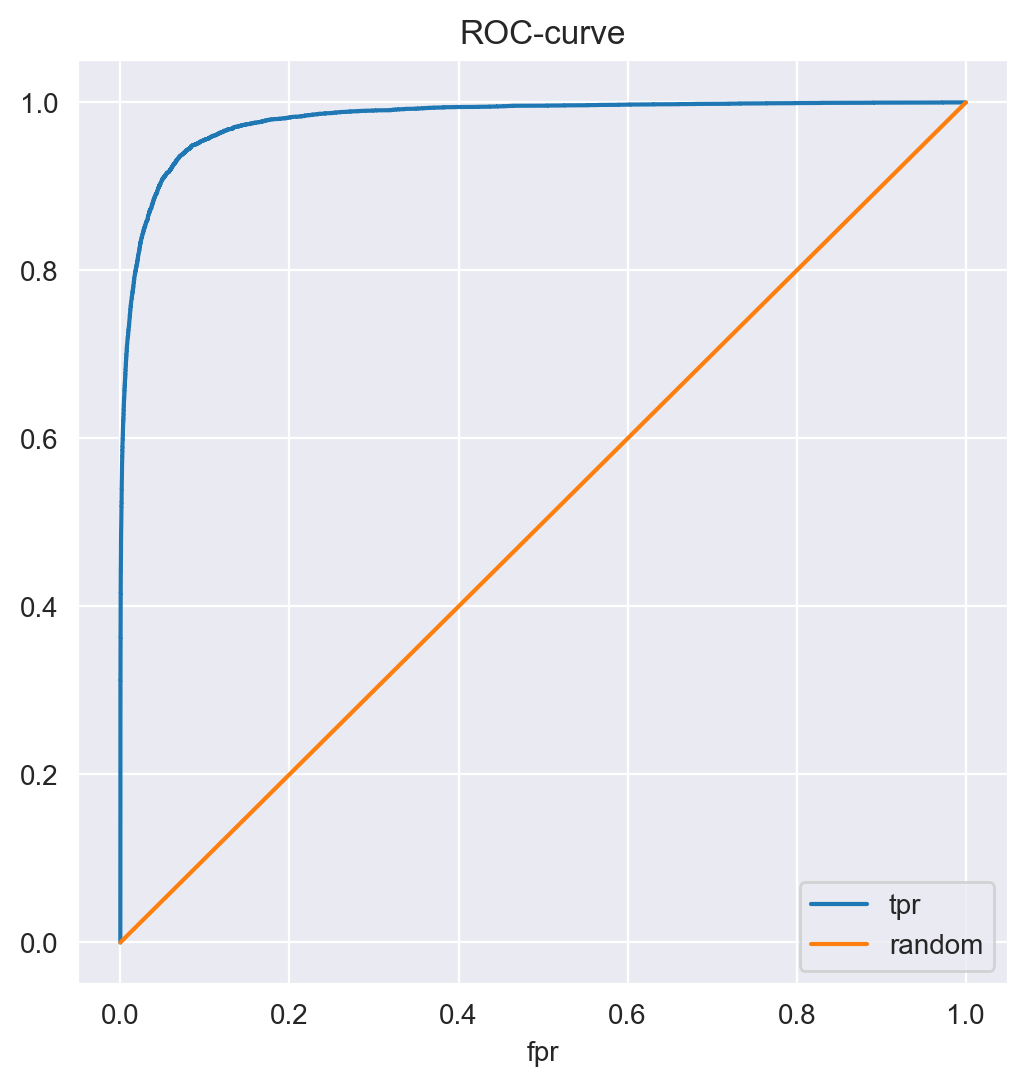

In [32]:
fpr, tpr, thr = roc_curve(t['y_true'],t['y_score'])
roc = pd.DataFrame({'fpr':fpr,'tpr':tpr,'thr':thr})
roc['random'] = roc['fpr'].copy()
roc.plot(x='fpr',y=['tpr','random'],figsize=(6,6),grid=True)
plt.title('ROC-curve')
plt.show()

In [33]:
auc(roc['fpr'],roc['tpr'])

0.9809704429518646

Показатель AUC очень хороший, скорее всего можно регулировать порог.

In [34]:
roc_auc_score(t['y_true'],t['y_score'])

0.9809704429518646

Найдём лучший порог.

In [35]:
roc['tpr - fpr'] = roc['tpr'] - roc['fpr']
best_thr = roc.sort_values('tpr - fpr',ascending=False).reset_index(drop=True)['thr'][0]
best_thr

0.43037356617015976

In [36]:
t['y_pred_{}'.format(best_thr)] = (t['y_score'] >= best_thr) * 1
t

,y_true,y_score,y_pred_0.5,y_pred_0.43037356617015976
104850,0,0.030,0,0
25,0,0.015,0,0
100683,0,0.002,0,0
102486,0,0.393,0,0
157045,0,0.003,0,0
...,...,...,...,...
135268,0,0.005,0,0
91076,0,0.094,0,0
149735,0,0.016,0,0
52802,0,0.007,0,0


In [37]:
f1_score(t['y_true'], t['y_pred_{}'.format(best_thr)])

0.7314412588087652

Переберём разные пороги.

In [41]:
max_score = score
best_p = 0

for _ in np.arange(0.49,0.91,0.02):
    tt = t.copy()
    tt['y_pred_{}'.format(_)] = (tt['y_score'] >= _) * 1
    print('Порог:',_)
    f1 = f1_score(t['y_true'], tt['y_pred_{}'.format(_)])
    print('f1_score:',f1)
    if f1 > max_score:
        print('Метрика улучшилась')
        max_score = f1
        best_p = _
                                 
    print()

t['y_pred_{}'.format(best_p)] = (t['y_score'] >= best_p) * 1

print('Итог:')
print('Лучший порог', best_p)
print('Лучший f1-score', max_score)

Порог: 0.49
f1_score: 0.7500879441177949

Порог: 0.51
f1_score: 0.7560578293626553
Метрика улучшилась

Порог: 0.53
f1_score: 0.7640681466184821
Метрика улучшилась

Порог: 0.55
f1_score: 0.7699942537742257
Метрика улучшилась

Порог: 0.5700000000000001
f1_score: 0.775574940523394
Метрика улучшилась

Порог: 0.5900000000000001
f1_score: 0.780323305855904
Метрика улучшилась

Порог: 0.6100000000000001
f1_score: 0.7844860320043396
Метрика улучшилась

Порог: 0.6300000000000001
f1_score: 0.789583562245907
Метрика улучшилась

Порог: 0.6500000000000001
f1_score: 0.7933433517003395
Метрика улучшилась

Порог: 0.6700000000000002
f1_score: 0.7976741560347748
Метрика улучшилась

Порог: 0.6900000000000002
f1_score: 0.8018528049408132
Метрика улучшилась

Порог: 0.7100000000000002
f1_score: 0.8045843945357721
Метрика улучшилась

Порог: 0.7300000000000002
f1_score: 0.8084482252860077
Метрика улучшилась

Порог: 0.7500000000000002
f1_score: 0.8129170638703527
Метрика улучшилась

Порог: 0.7700000000000002
f1

In [47]:
metrics(final, 'CatBoostClassifier_0.83', max_score, time_fit, time_pred)

,F1-score,Время обучения,Время предсказания
CatBoostClassifier,0.753,274.868,2.452
CatBoostClassifier_0.83,0.817,274.868,2.452


Регулирование порога привело к улучшеню метрики до 0.817, что является хорошим результатом.

In [43]:
print(classification_report(test[y_col],t['y_pred_{}'.format(best_p)]))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98     71553
           1       0.84      0.79      0.82      8093

    accuracy                           0.96     79646
   macro avg       0.91      0.89      0.90     79646
weighted avg       0.96      0.96      0.96     79646



Показатели precision и recall стали сбалансироваными.

## Выводы

- Изучение данных
  - В среднем каждый 10-й комментарий токсичный (10.2% токсичный комментариев по всей выборке)
  - Медийное количество слов в комментарии - 36, среднее - 67, стандартное отклонение довольно большое - 100, что говорит о большом разбросе в длинне сообщенией. Самый большой текст насчитывает 2273 слова


- Обучение моделей:
  - По метрике F1-score самой оптимальной моделью стала CatBoostClassifier с параметрами { early_stopping_rounds=100, text_features = text_features, verbose=100, auto_class_weights='Balanced'}.


- Тестирование:
  - Модель CatBoostClassifier достигла нужого качества, её F1-score на тестовой выборке составил 0.754.
  - Так как классы не сбалансированы , то я произвёл подбор лучшего порога и снова провёл оценку метрики F1-score, произошло значительое улучшение.
    - Лучший порог: 0.83
    - *финальный F1-score:* **0.817** 
    - precision: 0.84
    - recall: 0.79
      - Полнота и точность сбалансированы и практически равны, что говорит о том, что модель не перекошивается в какую-либо сторону, а значит работает максимально адекватно. 
   - Можно попробовать улучшить работу модели с помощью подбора гиперпараметров, но наврятли получиться добиться сильного улучшения. Так как CatBoost обучаеся медленно, особено на больших данных, каждый подбор параметров может занимать несколько часов.